In [8]:
import sys
import pickle
import numpy as np
import pandas as pd
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [9]:
df = pd.read_pickle('tmp/new_tensor_results_df.pkl')
df['mtx_is_dirichlet'] = df['mtx_is_dirichlet'].apply(lambda x: len(x) > 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


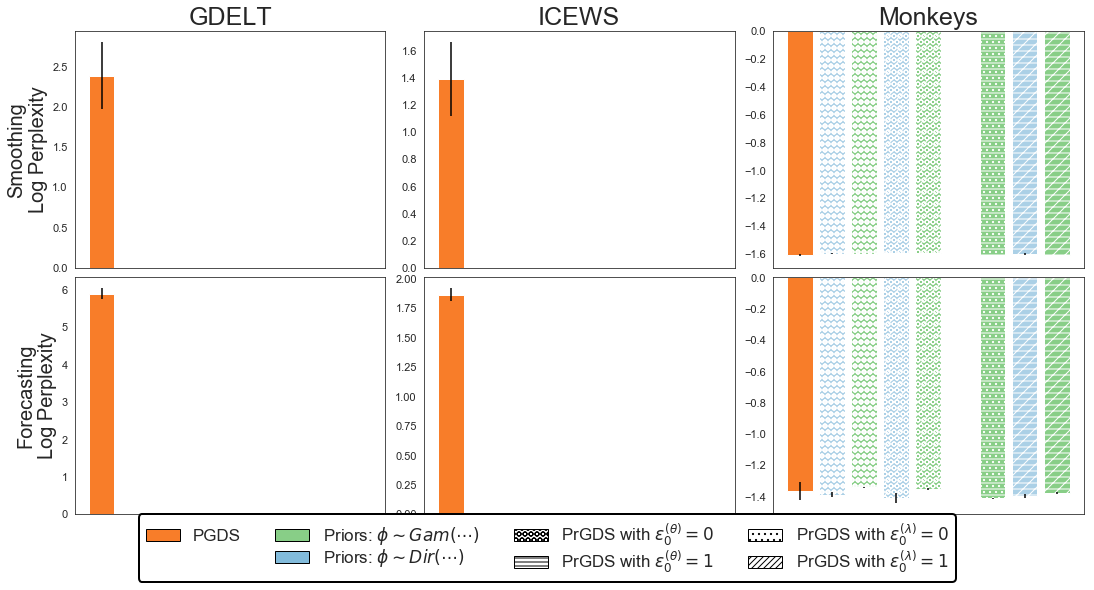

In [10]:
tPlot, axes = plt.subplots(nrows=3,
                           ncols=3, 
                           sharex=True, 
                           gridspec_kw={'height_ratios': [1,1,0.25],
                                        'width_ratios': [1,1,1]},
                           figsize=(15, 8))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.1, hspace=0.1)


width=2
space=width/4.

lines = []
labels = []
for row, metric in enumerate(['perp_s_nz', 'perp_f_nz']):
    for col, dataset in enumerate(['gdelt', 'icews', 'monkeybrains']):
        
        bptf_val = 1.
        ax = axes[row][col]
        
        foo = df.loc[(df['model_type'] == 'pgds') & 
                     (df.experiment.apply(lambda x: dataset in x))]
        vals = np.log([float(x) for x in foo[metric]])
        vals /= bptf_val
        
        label = 'PGDS'
        line = ax.bar(0, np.nanmean(vals), yerr=np.nanstd(vals), label='PGDS', 
               color=sns.color_palette("Oranges", 8)[4], width=width)
        
        if row == 0 and col == 0:
            labels.append(label)
            lines.append(line)

        xtick = width + space
        xticklabels = []
        blue_cmap = sns.color_palette("Blues", 8)
        purp_cmap = sns.color_palette("Greens", 8)
        
        for theta_eps, nu_eps, mtx_is_dirichlet in it.product([0,1],[0,1],[True,False]):

            foo = df.loc[(df['model_type'] == 'prgds-v3') & 
                         (df['theta_eps'] == theta_eps) & 
                         (df['nu_eps'] == nu_eps) & 
                         (df['mtx_is_dirichlet'] == mtx_is_dirichlet) &
                         (df.experiment.apply(lambda x: dataset in x))]

            if len(foo[metric]) == 0:
                vals = np.array([])
            else:
                vals = np.log([float(x) for x in foo[metric]])
                vals /= bptf_val

            if theta_eps == 0 and nu_eps == 0:
                hatch = 'OO..'
            elif theta_eps == 0 and nu_eps == 1:
                hatch = 'OO//'
            elif theta_eps == 1 and nu_eps == 0:
                hatch = '--..'
            else:
                hatch = '--//'

            color = blue_cmap[2] if mtx_is_dirichlet else purp_cmap[3]

            label ='PrGDS: $\\epsilon^{(\\theta)}{=}%d$, '% theta_eps
            label +='$\\epsilon^{(\\lambda)}{=}%d$, '% nu_eps
            label += 'Dir' if mtx_is_dirichlet else '$Gam$' 
            line = ax.bar(xtick, np.nanmean(vals), yerr=np.nanstd(vals), label=label, 
                    hatch=hatch, color=color, width=width)
            xtick += width + space
            xticklabels.append(label)
        
            if row == 0 and col == 0:
                labels.append(label)
                lines.append(line)
                
        if col == 0:
            if row == 0:
                ax.set_ylabel('Smoothing\nLog Perplexity', fontsize=20)
            else:
                ax.set_ylabel('Forecasting\nLog Perplexity', fontsize=20)
            
        
        if row == 0:
            title = dataset
            if title == 'gdelt':
                title = 'GDELT'
            elif title == 'icews':
                title = 'ICEWS'
            elif title == 'monkeybrains':
                title = 'Monkeys'
            ax.set_title(title, fontsize=25)
        
#         ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
        ax.set_xticks(np.arange(xtick))
#         ax.set_xticklabels(xticklabels, rotation=45, fontsize=5)
        ax.set_xticklabels(())
        ax.tick_params(axis='both', which='major', labelsize=11)

    #     for _ in range(12):
    #         plt.bar(xtick + _, 0)

lines = lines[1:] + [lines[0]]
labels = labels[1:] + [labels[0]]

for col in range(3):
    ax = axes[2][col]
    ax.set_xticks(())
    ax.set_yticks(())
    ax.axis('off')

LEGEND_ELEMENTS = [mpatches.Patch(facecolor=sns.color_palette("Oranges", 8)[4], 
                   edgecolor='Black', 
                   label='PGDS'),
                
                   mpatches.Patch(facecolor='White'),

                                      
                    mpatches.Patch(facecolor=purp_cmap[3], 
                    edgecolor='Black', 
                    label='Priors: $\phi \sim Gam(\cdots)$'),

                    mpatches.Patch(facecolor=blue_cmap[3], 
                    edgecolor='Black', 
                    label='Priors: $\phi \sim Dir(\cdots)$'),
                   
                   mpatches.Patch(facecolor='White', 
                    edgecolor='Black', 
                    hatch='O' * 2, 
                    label='PrGDS with $\\epsilon_0^{(\\theta)}{=}0$'),

                  mpatches.Patch(facecolor='White', 
                    edgecolor='Black', 
                    hatch='-' * 3, 
                    label='PrGDS with $\\epsilon_0^{(\\theta)}{=}1$'),

                   mpatches.Patch(facecolor='White', 
                    edgecolor='Black', 
                    hatch='.' * 2, 
                    label='PrGDS with $\\epsilon_0^{(\lambda)}{=}0$'),

                  mpatches.Patch(facecolor='White', 
                    edgecolor='Black', 
                    hatch='/' * 4, 
                    label='PrGDS with $\\epsilon_0^{(\lambda)}{=}1$')]

legend = plt.figlegend(handles=LEGEND_ELEMENTS,
              loc='lower center', 
              ncol=4,
              labelspacing=0.,
              framealpha=1.0,
              prop={'size':17},
              frameon=True)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('Black')
#         ylabel = 'Perplexity '
#         if 'nz' in metric: 
#             ylabel += 'on non-zeros'
#         elif 'z' in metric:
#             ylabel += 'on zeros'
#         plt.ylabel(ylabel)

#         title = 'Smoothing on ' if '_s' in metric else 'Forecasting on '
#         title += dataset.upper()
#         plt.title(title)
#     #     plt.legend(loc='lower right')

plt.tight_layout(pad=0.0, h_pad=None, w_pad=None, rect=None)
plt.savefig('tensor_results.pdf', dpi=100, pad_inches=0.0, format='pdf')

In [21]:
df = pd.read_pickle('tmp/new_tensor_results_df.pkl')
df['mtx_is_dirichlet'] = df['mtx_is_dirichlet'].apply(lambda x: len(x) > 0)

old_df = pd.read_pickle('tensor_results_df.pkl')
old_df['mtx_is_dirichlet'] = old_df['mtx_is_dirichlet'].apply(lambda x: len(x) > 0)

In [22]:
bptf_df = pd.read_pickle('bptf_results_df.pkl')
exp = bptf_df.experiment.unique()[0]

theta_eps = 0
nu_eps = 1
mtx_is_dirichlet = True
dataset = 'gdelt'
metric = 'perp_f_nz'
for exp in bptf_df.experiment.unique():
    bptf_val = float(bptf_df[bptf_df['experiment'] == exp][metric])
    
    foo = df.loc[(df['model_type'] == 'prgds-v2') & 
                 (df['theta_eps'] == theta_eps) & 
                 (df['nu_eps'] == nu_eps) & 
                 (df['mtx_is_dirichlet'] == mtx_is_dirichlet) &
                 (df['experiment'] == exp)]
    vals = np.array([float(x) for x in foo[metric]]) / bptf_val
    print(vals)
#     if len(vals) == 0:
#         print(foo)
#         print(exp)



# metric = 'perp_f_nz'
# foo[['experiment', metric]]
# bptf_df[['experiment', metric]]

[0.04315601 0.04472522]
[0.04216787 0.04294643]
[0.04313111 0.04297363]
[0.04251492 0.04384948]
[0.00135328 0.00150667]
[0.04171122 0.04063248]
[0.00138753 0.00126463]
[0.04078903 0.04203943]


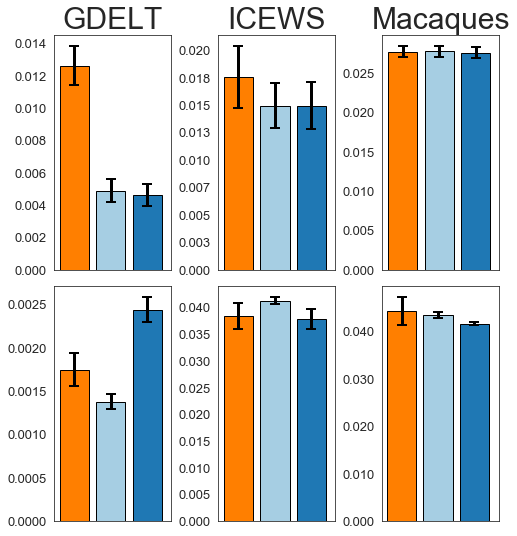

In [25]:
sns.set_style('white')

PGDS_COLOR = sns.color_palette("Paired")[7]
GPDPFA_COLOR = sns.color_palette("Paired")[5]
BPTF_COLOR = sns.color_palette("Paired")[10]
PRGDS0_COLOR = sns.color_palette("Paired")[0]
PRGDS1_COLOR = sns.color_palette("Paired")[1]

tPlot, axes = plt.subplots(nrows=2,
                           ncols=3, 
                           sharex=True, 
                           gridspec_kw={'height_ratios': [1,1],
                                        'width_ratios': [1,1,1]},
                           figsize=(7, 7.25))

width=2
space=width/4.

lines = []
labels = []
for row, metric in enumerate(['perp_s_nz', 'perp_f_nz']):
    for col, dataset in enumerate(['gdelt', 'icews', 'monkeybrains']):
        ax = axes[row][col]
        
        if row == 1 and col == 2:
            width = 2.1
        xtick = 0
        foo = df.loc[(df['model_type'] == 'pgds') & 
                     (df.experiment.apply(lambda x: dataset in x)) &
                     (df.experiment.apply(lambda x: 'structured' not in x)) & 
                     (df.experiment.apply(lambda x: 'periods6' in x))]

        vals = []
        for exper in foo.experiment.unique():
            bptf_val = float(bptf_df[bptf_df['experiment'] == exper][metric])
            vals += [x/bptf_val for x in foo[foo['experiment'] == exper] [metric]]
    

        label = 'PGDS'
        line = ax.bar(xtick, np.nanmean(vals), yerr=np.nanstd(vals), label='PGDS', 
                      color=PGDS_COLOR, width=width, error_kw=dict(lw=3, capsize=5, capthick=2),
                      edgecolor='k')
        
        if row == 0 and col == 0:
            labels.append(label)
            lines.append(line)

        xtick += width + space
        for theta_eps, nu_eps, mtx_is_dirichlet in it.product([0,1],[1],[True]):

            foo = df.loc[(df['model_type'] == 'prgds-v2') & 
                         (df['theta_eps'] == theta_eps) & 
                         (df['nu_eps'] == nu_eps) & 
                         (df['mtx_is_dirichlet'] == mtx_is_dirichlet) &
                         (df.experiment.apply(lambda x: dataset in x)) &
                         (df.experiment.apply(lambda x: 'structured' not in x)) & 
                         (df.experiment.apply(lambda x: 'periods6' in x))]

            vals = []
            for exper in foo.experiment.unique():
                bptf_val = float(bptf_df[bptf_df['experiment'] == exper][metric])
                vals += [x/bptf_val for x in foo[foo['experiment'] == exper] [metric]]

            color = PRGDS0_COLOR if theta_eps==0 else PRGDS1_COLOR

            line = ax.bar(xtick, np.nanmean(vals), yerr=np.nanstd(vals), label=label, 
                          color=color, width=width,error_kw=dict(lw=3, capsize=5, capthick=2),
                          edgecolor='k')
            xtick += width + space
        
            if row == 0 and col == 0:
                labels.append(label)
                lines.append(line)
            
        if col in [1,2]:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        if row == 0:
            title = dataset
            if title == 'gdelt':
                title = 'GDELT'
            elif title == 'icews':
                title = 'ICEWS'
            elif title == 'monkeybrains':
                title = 'Macaques'
            ax.set_title(title, fontsize=30)
        
        ax.set_xticks(np.arange(xtick))
        ax.set_xticklabels(())
        ax.tick_params(axis='both', which='major', labelsize=13)
        

# lines = lines[1:] + [lines[0]]
# labels = labels[1:] + [labels[0]]

# LEGEND_ELEMENTS = [mpatches.Patch(facecolor=PGDS_COLOR, 
#                    edgecolor='Black', 
#                    label='PGDS'),
                
#                    mpatches.Patch(facecolor='White'),
                   
#                    mpatches.Patch(facecolor=PRGDS0_COLOR, 
#                     edgecolor='Black', 
#                     label='PrGDS with $\\epsilon_0^{(\\theta)}{=}0$'),

#                   mpatches.Patch(facecolor=PRGDS1_COLOR,
#                     edgecolor='Black', 
#                     label='PrGDS with $\\epsilon_0^{(\\theta)}{=}1$')]

# legend = plt.figlegend(handles=LEGEND_ELEMENTS,
#               loc='lower center', 
#               ncol=2,
#               labelspacing=0.,
#               framealpha=1.0,
#               prop={'size':17},
#               frameon=True)
# legend.get_frame().set_linewidth(2)
# legend.get_frame().set_edgecolor('Black')

plt.tight_layout(pad=0.0, h_pad=None, w_pad=None, rect=None)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.4, hspace=0.07)

plt.savefig('test_tensor_results.pdf', dpi=100, pad_inches=0.0, format='pdf')